In [1]:
import numpy as np
import pickle

from gpu import set_gpu
from matplotlib import pyplot as plt
import loop as lp

set_gpu()

Num GPUs Available:  1


In [2]:
sub_type = 'TR'
with open('train_data_raw_'  + sub_type + '.p', 'rb') as f:
    raw, params,feat,feat_sq = pickle.load(f)

In [5]:
# Loop through noise
acc_all, acc_noise, acc_clean, file_name = lp.loop_sub(raw, params, sub_type, load=True, n_train='fullgaussflat1', train_scale=5, n_test='partflat1',test_scale=0,epochs=50, sparsity=True,dt='noise',feat_type='feat')
acc_all, acc_noise, acc_clean, file_name = lp.loop_noise(raw, params, sub_type, load=True, n_train='fullgaussflat1', train_scale=5, n_test='partgauss1',epochs=50, sparsity=True,dt='noise',feat_type='feat')

Running sub 1, model 2, latent dim 4
Running sub 2, model 2, latent dim 4
Running sub 3, model 2, latent dim 4
Running sub 4, model 2, latent dim 4
Running sub 5, model 2, latent dim 4
Running sub 6, model 2, latent dim 4
Running sub 1, model 2, latent dim 4
Running sub 2, model 2, latent dim 4
Running sub 3, model 2, latent dim 4
Running sub 4, model 2, latent dim 4
Running sub 5, model 2, latent dim 4
Running sub 6, model 2, latent dim 4


In [5]:
# Load noise results
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=50,n_train='fullgaussflat2',train_scale=5,n_test='partgauss1', latent_dim=4,loop_i='noise', dt='noise')
sub_all, sub_noise, sub_clean, flat_ave_all, flat_ave_noise, flat_ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=50,n_train='fullgaussflat2',train_scale=5,n_test='partflat1', latent_dim=4,loop_i='noise',dt='noise')
flat_ave_all = flat_ave_all[np.newaxis,...]
flat_ave_noise = flat_ave_noise[np.newaxis,...]
flat_ave_clean = flat_ave_clean[np.newaxis,...]

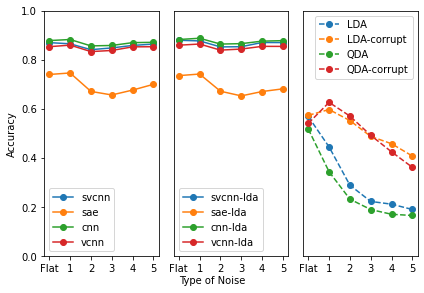

In [6]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_noise[0,i],ave_noise[:,i])),'-o')
for i in range(4,8):    
    ax[1].plot(np.hstack((flat_ave_noise[0,i],ave_noise[:,i])),'-o')
for i in range(8,12):    
    ax[2].plot(np.hstack((flat_ave_noise[0,i],ave_noise[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

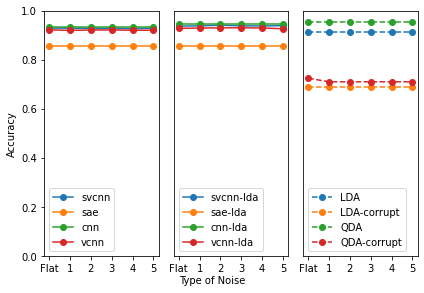

In [7]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_clean[0,i],ave_clean[:,i])),'-o')
for i in range(4,8):    
    ax[1].plot(np.hstack((flat_ave_clean[0,i],ave_clean[:,i])),'-o')
for i in range(8,12):    
    ax[2].plot(np.hstack((flat_ave_clean[0,i],ave_clean[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

In [ ]:
# loop through latent dimensions
sub_all, sub_noise, sub_clean, file_name = lp.loop_alldim(raw, params, sub_type, load=False, n_train='gaussflat', train_scale=3, n_test='gauss', test_scale=1,epochs=30, sparsity=True, dt='0414')

In [ ]:
# load results from latent dimension loop, sparse vs. not sparse
sub_all, sub_noise, sub_clean, sparse_all, sparse_noise, sparse_clean = lp.load_results(params, sub_type=sub_type,sparsity=True, dt='0414')
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.load_results(params, sub_type=sub_type,sparsity=False, dt='0414')

In [ ]:
# Plot accuracy vs. latent dimension
fig,ax = plt.subplots(1,2)
for i in range(0,4):
    ax[0].plot(ave_noise[:,i],'-o')
    ax[1].plot(sparse_noise[:,i],'-o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0.04, 'Latent Dimension', ha='center')
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0.5,1)
ax[0].legend(['svcnn','sae','cnn','vcnn'])